In [2]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import os,glob
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,concatenate, Bidirectional,LeakyReLU, SpatialDropout1D
from keras import Sequential
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
#!pip install bs4
from bs4 import BeautifulSoup

In [3]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
#le=LabelEncoder()

In [4]:
'''
Function to clean up the HTML file to get only the content and not the structure
Uses beautifulsoup - common library for HTML parsing to remove all javascript and css content
Then the HTML tags are removed followed with removing of junk characters
'''
def cleanhtml(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    for script in soup(["script", "style"]):
        script.extract()
    text = soup.get_text()
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    text = '\n'.join(chunk for chunk in chunks if chunk)
    text = BAD_SYMBOLS_RE.sub('', text)
    '''
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    '''
    return text

In [15]:
'''
Load data from files for the top 10 classes from the AZSecure Dataset and Phishtank Dataset
'''
os.chdir("/home/arulthileeban/PKI/HTML_Dataset/pages_r/")

files=glob.glob("*")
X,Y=[],[]
classes=['Adobe','PayPal','Binance','Orange','MyEtherWallet','Facebook','Yahoo','Microsoft']
for i in files:
    try:
        class_val=''.join([j for j in i if j.isalpha()])
        if class_val in classes:
            X.append(open(i).read())
            Y.append(class_val)
    except:
        pass
    
os.chdir("/home/arulthileeban/PKI/HTML_Dataset/pt/pages_r/")

files=glob.glob("*")
classes=['Adobe','PayPal','Binance','Orange','MyEtherWallet','Facebook','Yahoo','Microsoft']
for i in files:
    try:
        class_val=''.join([j for j in i if j.isalpha()])
        if class_val in classes:
            X.append(open(i).read())
            Y.append(class_val)
    except:
        pass
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(classes)

In [16]:
X = [cleanhtml(i) for i in X]
X = np.array(X)
Y = np.array(label_tokenizer.texts_to_sequences(Y))

In [17]:
#Setting params and tokenizing the content
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100
epochs = 30
batch_size = 64
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [18]:
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

In [20]:
#Model 
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(EMBEDDING_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(classes)+1, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909       
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,callbacks=[EarlyStopping(monitor='accuracy', patience=3, min_delta=0.0001)])

Epoch 1/30
19/19 [==============================] - 1s 63ms/step - loss: 1.9808 - accuracy: 0.3281
Epoch 2/30
19/19 [==============================] - 1s 63ms/step - loss: 1.6431 - accuracy: 0.3873 0s - loss: 1.689
Epoch 3/30
19/19 [==============================] - 1s 62ms/step - loss: 1.3831 - accuracy: 0.5197
Epoch 4/30
19/19 [==============================] - 1s 63ms/step - loss: 1.0984 - accuracy: 0.6250
Epoch 5/30
19/19 [==============================] - 1s 63ms/step - loss: 0.8818 - accuracy: 0.6908
Epoch 6/30
19/19 [==============================] - 1s 63ms/step - loss: 0.7370 - accuracy: 0.7706
Epoch 7/30
19/19 [==============================] - 1s 62ms/step - loss: 0.6501 - accuracy: 0.7821
Epoch 8/30
19/19 [==============================] - 1s 64ms/step - loss: 0.5607 - accuracy: 0.8199
Epoch 9/30
19/19 [==============================] - 1s 62ms/step - loss: 0.5092 - accuracy: 0.8215
Epoch 10/30
19/19 [==============================] - 1s 62ms/step - loss: 0.4777 - accuracy:

In [22]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

10/10 [==============================] - 0s 9ms/step - loss: 0.8323 - accuracy: 0.7705
Test set
  Loss: 0.832
  Accuracy: 0.770


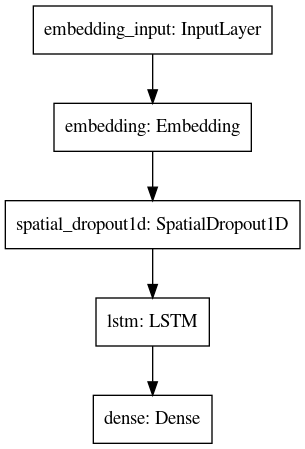

In [13]:
from keras.utils import plot_model
plot_model(model, to_file='html_model.png')

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
yhat_probs = model.predict(X_test, verbose=0)
yhat_classes=yhat_probs.argmax(axis=-1)
yhat_probs = yhat_probs[:, 0]
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
precision = precision_score(Y_test, yhat_classes,average='macro')
print('Precision: %f' % precision)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)

Accuracy: 0.770492
Precision: 0.805853
Recall: 0.727345
